<a href="https://colab.research.google.com/github/aishakhan22/ImageProcessing/blob/Stage1/withGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel image processing using Pycuda 
A method is proposed to segment images using multi-threaded programming and classifies brain tumor MRI images 

* The model uses notable preprocessing methodologies
* k-means clustering algorithm for segmentation 
* Segmentation deployed on a GPU environment provided by [NVIDIA CUDA](https://developer.nvidia.com/pycuda) accessed by pycuda v2019.1.2 python library
* Feature extraction method used in this project is Gray-Level Co-Occurrence Matrix 
* implements 2 layer Convolutional neural network 
* The dataset used for the model learning is [BRATS2013](http://braintumorsegmentation.org/)


### Installing dependencies to carry out GPU implementation 

In [ ]:
!pip install pycuda
!pip install pydicom
!pip install dipy

     |████████████████████████████████| 1.6MB 9.0MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4537155 sha256=3bd061c5c6d6e007b1523c5c047ab69869c7b7d26cc3ee73aa6f8b1ccab74822
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.4-py2.py3-none-any.whl size=67173 sha256=82505a870361378815ad7dcff18333f4c7b56cd7c7dbb565ea1934a2fe1b9185
  Stored in directory: /root/.cache/pip/wheels/5e/20/0b/fac51840734b2587ecc239a62522b164c374e929e2c9be66c5
Successfully built pycuda pytools
     |████████████████████████████████| 35.5MB 89kB/s 
     |████████████████████████████████| 8.1MB 8.6MB/s 


In [ ]:
pycuda.VERSION

(2019, 1, 2)

### Importing required python libraries 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf 
import glob
from sklearn.model_selection import train_test_split
import cv2
import random
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import time 

### CONFIG 

In [ ]:
#import os
train_path = '/content/drive/My Drive/GoogleColab/brats2013_/train'
validation_path = '/content/drive/My Drive/GoogleColab/brats2013_/holdout'
train_dir_type = os.path.join(train_path, 'segmentation')
validation_dir_type = os.path.join(validation_path, 'segmentation')


######################Understanding###############################
train_path_und = '/content/drive/My Drive/GoogleColab/brats2013/train'
validation_path_und = '/content/drive/My Drive/GoogleColab/brats2013/holdout'
train_dir_type_und = os.path.join(train_path_und, 'segmentation')
validation_dir_type_und = os.path.join(validation_path_und, 'segmentation')
train_true_dir = os.path.join(train_dir_type_und, 'True') 
train_false_dir = os.path.join(train_dir_type_und, 'False') 
validation_true_dir = os.path.join(validation_dir_type_und, 'True') 
validation_false_dir = os.path.join(validation_dir_type_und, 'False')  


### Understanding the dataset

* [Follow the link to download BRATS2013 dataset](https://datasetsearch.research.google.com/search?query=BRATS2013%20Tumor-NoTumor%20Dataset%20(T-NT)&docid=Gxy5yuwh%2FGkiC4M2AAAAAA%3D%3D)

In [ ]:
Ttrue_tumor_img = len(os.listdir(train_true_dir))
Tfalse_tumor_img = len(os.listdir(train_false_dir))

Vtrue_tumor_img = len(os.listdir(validation_true_dir))
Vfalse_tumor_img = len(os.listdir(validation_false_dir))

total_train = Ttrue_tumor_img + Tfalse_tumor_img
total_val = Vtrue_tumor_img + Vfalse_tumor_img

print(f'total number of train_dataset are {total_train}')
print(f'total number of validation image data set are {total_val}')

total number of train_dataset are 2125
total number of validation image data set are 1415


In [ ]:
import re
def create_label_corresponding(location):
  _file=[]
  _label=[] 
  image_list = location + '/*.png'  
  data = glob.glob(image_list)
  for i in data:
    str =re.sub('[^A-Za-z0-9]+', ' ', i)
    if 'True' in str:
      _file.append(i)
      _label.append(1)
    elif 'False' in str:
      _file.append(i)
      _label.append(0)
    else:
      print("Exception")
  return _file , _label

In [ ]:
_file, _label = create_label_corresponding(train_dir_type)


In [ ]:
_vfile, _vlabel = create_label_corresponding(validation_dir_type)


In [ ]:
complete_file_lst = _file + _vfile

In [ ]:
_complete_label_lst = _label + _vlabel


In [ ]:
complete_file_lst[3000]

'/content/drive/My Drive/GoogleColab/brats2013_/holdout/segmentation/LG0014-91-True.png'

In [ ]:
_complete_label_lst[3000]

1

## Load the files and labels 



In [ ]:
def load_data(file_list_arr):
  IMG_HEIGHT = 150
  IMG_WIDTH = 150
  image_data = []
  for file in file_list_arr:
    path = file
    #print(type(path))
    image = tf.keras.preprocessing.image.load_img(path
      , grayscale=False, target_size=(IMG_HEIGHT,IMG_WIDTH),
      interpolation='nearest')
    print(image)
    image_data.append(image)

  return image_data


#Load the dataset into a pillow image object
 * first we create label for the corresponding files 
 * we parse substring 'True' and 'False' and create an array consisting of 0 and 1 
 * 0 represents False 
 * 1 represent True 
 * the values in the _file array is mapped to _label array accurately

In [ ]:
import time
time_load_start = time.time()
loaded_image = load_data(complete_file_lst)
time_load_end = time.time() - time_load_start 

<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39ED426D8>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93828>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93C50>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93CC0>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93DD8>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93E48>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93EB8>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93F28>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC93F98>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C048>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C0B8>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C128>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C198>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C208>
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FC39EC9C278>
<PIL.Image.Image image mode=RGB size=150

# Proportional split 

* 70% Training dataset 
* 30% Testing dataset 

In [ ]:
time_split_start = time.time()
x_train, x_test, y_train, y_test = train_test_split(loaded_image, _complete_label_lst, test_size=0.3, shuffle=True)
time_split_end = time.time() - time_split_start

In [ ]:
len(x_test)

1062

## Manual Inference 

In [ ]:
for i in y_test:
  if i == 1:
    print("yes")
  else:
    print("no")

yes
no
yes
yes
yes
yes
no
no
yes
yes
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
no
yes
yes
no
yes
yes
yes
yes
yes
yes
yes
yes
yes
no
yes
yes
yes
no
yes
no
yes
yes
yes
yes
yes
yes
yes
yes
yes
no
yes
yes
yes
yes
no
no
no
no
yes
yes
yes
no
yes
no
no
yes
yes
yes
yes
no
no
yes
no
yes
yes
yes
no
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
yes
no
yes
yes
no
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
no
yes
yes
yes
yes
yes
no
no
no
yes
yes
no
no
no
no
no
yes
yes
yes
yes
yes
yes
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
no
yes
yes
yes
yes
yes
yes
no
no
yes
yes
yes
yes
yes
yes
yes
no
no
yes
yes
yes
yes
yes
yes
yes
yes
yes
no
no
yes
no
no
yes
no
yes
yes
yes
yes
yes
no
yes
yes
no
no
no
yes
no
yes
yes
yes
yes
no
yes
no
yes
yes
no
yes
no
yes
yes
yes
yes
yes
yes
yes
yes
yes
no
no
yes
no
yes
yes
no
yes
yes
yes
no
no
yes
no
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
yes
yes
yes
yes
yes
no
yes
no
yes
no
no
no
yes
yes
yes
yes
yes
yes
yes
yes
yes
no
yes
no
no
yes
yes
yes
yes
yes
no
yes
yes
yes
yes
yes
no
yes
y

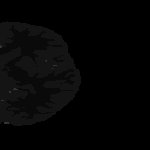

In [ ]:
x_test[6]

## Preprocessing the image data 
* subjected to training dataset and testing dataset 

## Preprocessing Class involves the following process(methods)
* denoising
* edge enhacement 
* improving contrast


In [ ]:
def check_dim(image_array):
  for i in image_array:
    I = np.asarray(i)
    if I.ndim == 2:
      print("dimension mismatch")
    else:
      #print(f'{i} and {I.ndim} ')
      pass
  return True



In [ ]:

class Preprocess(object):
  def __init__(self):
    #self.dataset = random.shuffle(dataset)
    self.ret_data = []
  def prepro_enhance_edge(self, dataset):
    for images in dataset:
      image = images.filter(ImageFilter.EDGE_ENHANCE_MORE())
      self.ret_data.append(image)
    return self.ret_data
  def prepro_enhance_contrast(self, dataset):
    for images in dataset:
      enhancer = ImageEnhance.Contrast(images)
      image = enhancer.enhance(4)
      self.ret_data.append(image)
    return self.ret_data
  def prepro_denoise(self, dataset):
    for images in dataset:
      image =images.filter(ImageFilter.BoxBlur(0.5))
      self.ret_data.append(image)
    return self.ret_data




In [ ]:
preprocess_start = time.time()
if check_dim(x_train) == True and check_dim(x_test) == True:
  #train_array1 = random.shuffle(train_array)
  #len(train_array)
  obj_edge = Preprocess()
  enhanced_edge = obj_edge.prepro_enhance_edge(x_train)
  #enhanced_const = obj_edge.prepro_enhance_contrast(enhanced_edge)
  obj_en = Preprocess()
  enhanced_const = obj_en.prepro_enhance_contrast(enhanced_edge)

  obj_denoise = Preprocess()
  denoise_gauss = obj_denoise.prepro_denoise(enhanced_const)

preprocess_end = time.time() - preprocess_start


In [ ]:
 postPreprocess_dataset= denoise_gauss

## Feature Extraction: GLCM

* A statistical method of examining texture that considers the spatial relationship of pixels
* describes how many times a certain gray level occurs next to other gray levels in an image.
* Energy, Entropy, Contrast, Mean, Homogeneity, Correlation
* Model can use the  entropy, energy, constrast, homogeneity and mean 
* The following chooses mean glcm features 

In [ ]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean

def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm std
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std


def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene


def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm max
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    max_  = np.max(glcm, axis=(0,1))
    return max_


def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent

In [ ]:
def perform_feature_extraction_glcm(data):
  glcm_mean = []
  glcm_hom = []
  glcm_ent = []
  for i in data:
    nbit = 8
    ks = 5
    mi, ma = 0, 255
    image = np.asarray(i)
    _2dimage = image[:,:,0]
    h,w  = _2dimage.shape
    glcm_mean_image = fast_glcm_mean(_2dimage)
    glcm_mean.append(glcm_mean_image)
    glcm_hom_image = fast_glcm_homogeneity(_2dimage)
    glcm_hom.append(glcm_hom_image)
    glcm_ent_image = fast_glcm_entropy(_2dimage)
    glcm_ent.append(glcm_ent_image)

  return glcm_mean, glcm_hom, glcm_ent

In [ ]:
fea_time_start = time.time()
glcm_mean, glcm_hom, glcm_ent = perform_feature_extraction_glcm(postPreprocess_dataset)
fea_time_stop = time.time()-fea_time_start

In [ ]:
_import matplotlib.pyplot as plt
def plotImages_glcm_mean(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

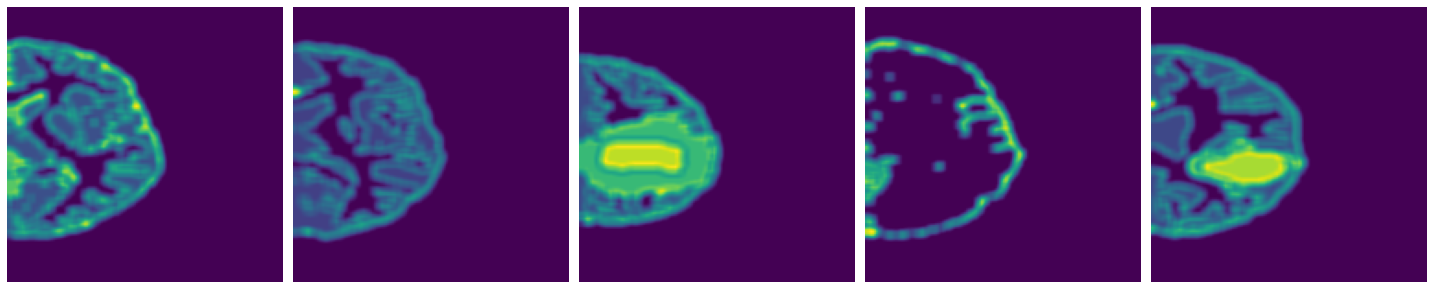

In [ ]:
plotImages_glcm_mean(glcm_mean[20:25])

In [ ]:
def convert_to_2d(array):
  _2d = []
  for i in array:
    image = cv2.cvtColor(np.asarray(i),cv2.COLOR_RGB2GRAY)
    _2d.append(image)
  return _2d


In [ ]:
_2darray = convert_to_2d(postPreprocess_dataset)

In [ ]:
np.asarray(_2darray[1]).shape

(150, 150)

## Kmeans Segmentation using CUDA 


* Uses the C++ source code for hyper threading 
* method calls are invoked by python wrappers 


In [ ]:
#image = cv2.cvtColor(np.asarray(postPreprocess_dataset[90]),cv2.COLOR_RGB2GRAY)
K1 = np.ones((3, 3), np.uint16)

mask1 = cuda_kmeans(glcm_mean[3], 3)

mask1.shape
image3 = cv2.cvtColor(mask1,cv2.COLOR_GRAY2RGB)
image3.shape

(150, 150, 3)

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import cv2 as cv
import numpy as np
from dipy.segment.mask import median_otsu
from pydicom import Dataset

from jinja2 import Template
import numpy as np

BLOCKDIM = 1024

SRC = '''
    #define N {{N}}
    #define BLOCKDIM 1024
    
    struct Cluster{
        float sum;
        int count;
    };
    
    __device__ Cluster clusters_d[(N + BLOCKDIM - 1) / BLOCKDIM];
    
    __device__ float euclidian_dist(const float a, const float b){
        float dist = a - b;
        return hypotf(dist, dist);
    }
    
    __global__ void relabel(const float* src, const float* clusters, int n, int nClusters, int* labels){
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        if(pos < n){
            float minDist = 1.0f;
            int clusterIndex = 0;
            for(int c = 0; c < nClusters; c++){
                float dist = euclidian_dist(src[pos], clusters[c]);
                if(dist <= minDist){
                    clusterIndex = c;
                    minDist = dist;
                }
            }
            labels[pos] = clusterIndex;
        }
    }
    
    __global__ void calculateClusters(const float* src, const int* labels, int n, int clusterIndex){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = Cluster();
        _clusters[tid].sum = 0.0f;
        _clusters[tid].count = 0;
        if(pos < n && labels[pos] == clusterIndex){
            _clusters[tid].sum = src[pos];
            _clusters[tid].count = 1;
        }
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(threadIdx.x < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(threadIdx.x < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(threadIdx.x == 0){
            clusters_d[blockIdx.x].sum = _clusters[0].sum;
            clusters_d[blockIdx.x].count = _clusters[0].count;
        }
    }
    
    __global__ void findCenters(int n, int clusterIndex, float* dst){
        extern __shared__ Cluster _clusters[];
        int pos = threadIdx.x + blockIdx.x * blockDim.x;
        int tid = threadIdx.x;
        _clusters[tid] = clusters_d[pos];
        __syncthreads();
        for(unsigned int stride = blockDim.x / 2; stride > 0; stride /= 2){
            if(tid < stride){
                _clusters[tid].sum += _clusters[tid + stride].sum;
            }
            __syncthreads();
            if(tid < stride){
                _clusters[tid].count += _clusters[tid + stride].count;
            }
            __syncthreads();
        }
        __syncthreads();
        if(tid == 0){
            dst[clusterIndex] = _clusters[0].count > 0 ? _clusters[0].sum / (_clusters[0].count * 1.0f) : 0.0f;
        }
    }
'''

def cuda_kmeans(img_data, n_clusters):
  segmented_images = []
  time_taken_ = []
  K1 = np.ones((3, 3), np.uint16)
  for i in img_data:
    img = np.asarray(i)
    w = img.shape[1]
    h = img.shape[0]
    n = w * h
    max_it = 30

    #img = cv.blur(img, (13, 13))
    src = img.reshape((-1,3))

    module = SourceModule(Template(SRC).render(N=n))
    relabel = module.get_function('relabel')
    calculate_clusters = module.get_function('calculateClusters')
    find_centers = module.get_function('findCenters')

    start_time = time.time()
    centers = np.random.rand(n_clusters).astype(np.float32)

    # Image
    src_gpu = cuda.mem_alloc(src.nbytes)
    cuda.memcpy_htod(src_gpu, src)

    # Cluster centers

    centers_gpu = cuda.mem_alloc(centers.nbytes)
    cuda.memcpy_htod(centers_gpu, centers)

    # Labels
    labels = np.empty_like(src).astype(np.int32)
    labels_gpu = cuda.mem_alloc(labels.nbytes)
    cuda.memcpy_htod(labels_gpu, labels)
        
    start = cuda.Event()
    end = cuda.Event()
        
    #t1 = time() * 1000
    
    start.record()
    start_time = time.time()
    for it in range(max_it):
      relabel(src_gpu, centers_gpu, np.int32(n), np.int32(n_clusters), labels_gpu,
              block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1))
      for c in range(n_clusters):
        calculate_clusters(src_gpu, labels_gpu, np.int32(n), np.int32(c),
                           block=(BLOCKDIM, 1, 1), grid=((n + BLOCKDIM - 1) // BLOCKDIM, 1),
                           shared=8 * BLOCKDIM)
        find_centers(np.int32(n), np.int32(c), centers_gpu,
                     block=((n + BLOCKDIM - 1) // BLOCKDIM, 1, 1), grid=((1, 1)),
                     shared=8 * (n + BLOCKDIM - 1) // BLOCKDIM)

        
    end.record()
    end.synchronize()
      
    elapse_time = time.time() - start_time
    cuda.memcpy_dtoh(labels, labels_gpu)
    cuda.memcpy_dtoh(centers, centers_gpu)
#
    labels = labels.reshape((-1))
    c_index = np.argmax(centers)
    flat = np.full(n, 0, dtype=np.uint8)
    flat[labels == c_index] = 1
    mask = flat.reshape((h, w))
    image = mask
    segmented_images.append(image)
    time_taken_.append(elapse_time)


        #mask = cv.erode(mask, kernel=K1, iterations=1)
        #mask = cv.dilate(mask, kernel=K1, iterations=1)
  return segmented_images, time_taken_
        #t1 = time() * 1000
        #msecs += t1 - t0

In [ ]:
#image = cv2.cvtColor(np.asarray(postPreprocess_dataset[90]),cv2.COLOR_RGB2GRAY)
#K1 = np.ones((3, 3), np.uint16)
time_seg_start = time.time()
gpu_seg, time_taken_ = cuda_kmeans(glcm_mean, 5)
time_seg_end = time.time()-time_seg_start

In [ ]:
time_taken_

[0.0048601627349853516,
 0.003888845443725586,
 0.004045009613037109,
 0.0038292407989501953,
 0.00374603271484375,
 0.004216194152832031,
 0.003670215606689453,
 0.003739595413208008,
 0.0050809383392333984,
 0.005135059356689453,
 0.005156040191650391,
 0.004890918731689453,
 0.004982948303222656,
 0.0047833919525146484,
 0.004756927490234375,
 0.0050275325775146484,
 0.004813194274902344,
 0.004795551300048828,
 0.00518488883972168,
 0.004944324493408203,
 0.0048105716705322266,
 0.004909515380859375,
 0.004786252975463867,
 0.005418300628662109,
 0.004929542541503906,
 0.0051288604736328125,
 0.004960775375366211,
 0.0048253536224365234,
 0.005026340484619141,
 0.005013704299926758,
 0.004925727844238281,
 0.004765987396240234,
 0.0049664974212646484,
 0.00489354133605957,
 0.004791259765625,
 0.004927396774291992,
 0.005184173583984375,
 0.00778508186340332,
 0.0051572322845458984,
 0.005031108856201172,
 0.0048601627349853516,
 0.005133152008056641,
 0.004828691482543945,
 0.0047

In [ ]:
import pandas as pd

df = pd.DataFrame(data=time_taken_,columns=['GPU_time'])
df.head()
df.to_csv('Time2_data.csv',header=True)
data = pd.read_csv("Time_data.csv")
data.head()
df2 = data.assign(GPU_time = time_taken_)

In [ ]:
df2.to_csv('TimeComb.csv', header=True)

In [ ]:
df2.head()
for col in df2.columns: 
    print(col)
df2 = df2.rename(columns={'Unnamed: 0': 'Image'})

Unnamed: 0
CPU_time
GPU_time


In [ ]:
df2.head()

,Image,CPU_time,GPU_time
0,0,0.097182,0.004860
1,1,0.066220,0.003889
2,2,0.046249,0.004045
3,3,0.061837,0.003829
4,4,0.071736,0.003746


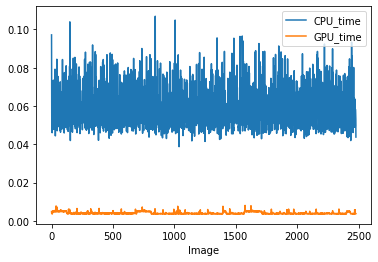

In [ ]:
df2.plot(x="Image", y=["CPU_time", "GPU_time"])
plt.show()

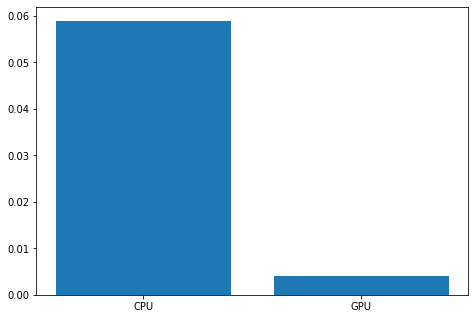

In [ ]:
CPU = df2["CPU_time"].mean()
GPU = df2["GPU_time"].mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Time consumed by the devices for k means segmentation')
hardware = ['CPU', 'GPU']
time_mean = [CPU, GPU]
ax.bar(hardware,time_mean)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

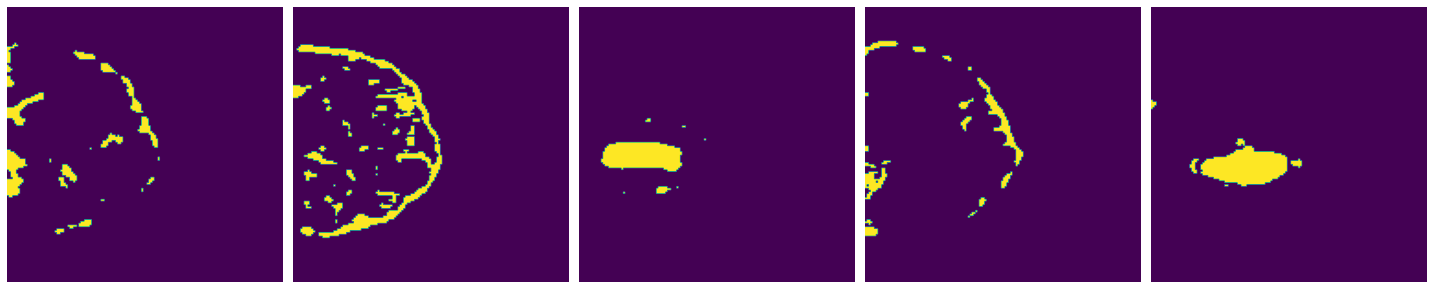

In [ ]:
plotImages(gpu_seg[20:25])

In [ ]:
def convert_to_3d(data):
  dim_3 = []
  for i in data:
    image = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
    dim_3.append(image)
  return dim_3

## Preparation of validation dataset 
* Goes through the same process as the training dataset 

In [ ]:
def prepare_val(dataset):
  #Preprocess
  Vobj_edge = Preprocess()
  Venhanced_edge = Vobj_edge.prepro_enhance_edge(dataset)
  #enhanced_const = obj_edge.prepro_enhance_contrast(enhanced_edge)
  Vobj_en = Preprocess()
  Venhanced_const = Vobj_en.prepro_enhance_contrast(Venhanced_edge)

  Vobj_denoise = Preprocess()
  Vdenoise_gauss = Vobj_denoise.prepro_denoise(Venhanced_const)

  VPreprocess = Vdenoise_gauss

  #FeatureExtraction
  Vglcm_mean, Vglcm_hom, Vglcm_ent = perform_feature_extraction_glcm(VPreprocess)


  return Vglcm_mean, Vglcm_hom, Vglcm_ent

In [ ]:
val_time = time.time()
Vglcm_mean, Vglcm_hom, Vglcm_ent = prepare_val(x_test)
val_time_end = time.time() - val_time

In [ ]:
#Segmentation 

Vsegmented_data, vtime = cuda_kmeans(Vglcm_mean, 5)

#Preparation of data that are to be fed to the machine learning model according to the model specification 

* the image data should be collection of numpy array 
* the image data should be of 3 dimension 

In [ ]:
dim_3_V = convert_to_3d(Vsegmented_data)
dim_3 = convert_to_3d(gpu_seg)

In [ ]:
train_image = np.array(dim_3)
train_label = np.array(y_train)
val_image = np.array(dim_3_V)
val_label = np.array(y_test)

## Model Build

In [ ]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150


## Model Information 

* Model involves 2 layers of convolution neural network 
* the kernel size is 3*3
* the activation function is relu 
* each convolutional layer is appended with max pooling layer 
* A dropout layer is add to avoid overfitting 
 

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu',  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives()])

In [ ]:
train_time = time.time()
history = model.fit(train_image,train_label,epochs=15,verbose=1,validation_data=(val_image,val_label),shuffle=False,callbacks=[callback])
train_time_end = time.time() - train_time

Epoch 1/15
78/78 [==============================] - 3s 39ms/step - loss: 0.5462 - accuracy: 0.7163 - precision: 0.9040 - recall: 0.6620 - false_positives: 121.0000 - false_negatives: 582.0000 - true_positives: 1140.0000 - true_negatives: 635.0000 - val_loss: 0.5001 - val_accuracy: 0.8465 - val_precision: 0.8950 - val_recall: 0.8867 - val_false_positives: 78.0000 - val_false_negatives: 85.0000 - val_true_positives: 665.0000 - val_true_negatives: 234.0000
Epoch 2/15
78/78 [==============================] - 2s 29ms/step - loss: 0.4826 - accuracy: 0.8753 - precision: 0.9585 - recall: 0.8577 - false_positives: 64.0000 - false_negatives: 245.0000 - true_positives: 1477.0000 - true_negatives: 692.0000 - val_loss: 0.4785 - val_accuracy: 0.8851 - val_precision: 0.9325 - val_recall: 0.9027 - val_false_positives: 49.0000 - val_false_negatives: 73.0000 - val_true_positives: 677.0000 - val_true_negatives: 263.0000
Epoch 3/15
78/78 [==============================] - 2s 29ms/step - loss: 0.4611 - acc

In [ ]:
value = model.predict(val_image)

In [ ]:
np.savetxt('test2.txt', value, fmt='%d')

In [ ]:
total_time = time_load_end + preprocess_end + fea_time_stop + time_seg_end + train_time_end + val_time_end

In [ ]:
m,s = divmod(total_time, 60)
print(m)

28.0


In [ ]:
tf.math.confusion_matrix(
    val_label, value, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[311,   1],
       [108, 642]], dtype=int32)>

In [ ]:
value[1]

array([1.5238719e-05], dtype=float32)

## saving the weights to reuse it 

In [ ]:
model.save('my_h5_modelGPU.h5')

In [ ]:
countmatch = 0
countnmatch = 0
for i in range(len(y_test)):
  if np.allclose(value[i],val_label[i]):
    countmatch = countmatch +1 
  else:
    countnmatch = countnmatch + 1

In [ ]:
countmatch

920

In [ ]:
!cat test2.txt

1
0
1
1
0
1
0
0
1
1
1
1
0
1
1
1
1
0
1
1
1
0
1
0
0
1
0
1
1
1
1
1
1
1
0
1
1
0
0
1
0
1
1
1
1
0
0
1
1
0
0
1
1
1
1
0
0
0
0
1
1
0
0
1
0
0
1
1
1
1
0
0
1
0
1
0
1
0
1
1
0
1
1
1
1
0
1
0
1
1
0
1
1
0
1
0
0
1
0
1
1
0
1
1
1
0
0
1
1
1
1
0
0
0
1
1
0
0
0
0
0
1
1
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
0
0
1
1
1
0
0
1
1
1
0
0
0
1
0
0
1
0
1
1
0
0
1
0
1
0
0
0
0
1
0
1
1
1
0
0
0
0
1
0
0
1
0
1
1
1
1
0
1
1
1
1
0
0
0
0
1
1
0
0
1
1
0
0
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
0
1
0
0
0
1
1
1
0
1
1
1
1
1
0
1
0
0
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
0
0
1
0
1
0
0
0
0
0
1
1
1
1
0
0
1
1
1
0
1
0
0
0
1
0
0
0
1
1
0
1
1
1
0
0
1
0
1
0
0
0
0
1
1
0
1
1
0
0
0
1
1
1
0
1
0
1
0
0
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
0
1
1
0
0
1
1
1
0
0
0
1
0
1
1
0
0
1
1
0
1
0
0
0
1
0
1
0
0
0
1
1
1
1
0
0
1
1
0
1
1
1
0
0
0
1
1
1
0
1
0
0
1
1
0
0
0
0
1
0
1
1
0
0
1
1
1
0
1
1
1
1
1
0
1
0
1
1
0
0
1
1
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
0
0
0
1
0
1
0
0
0
0
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1


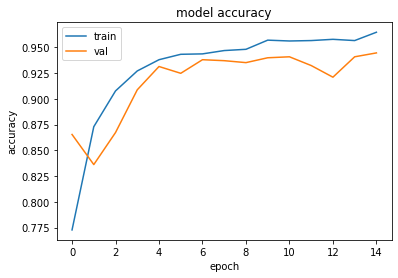

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               44859904  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

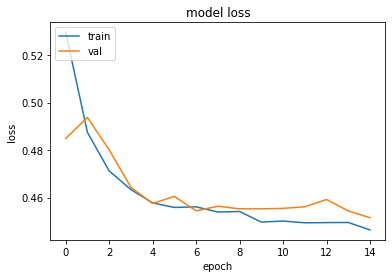

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

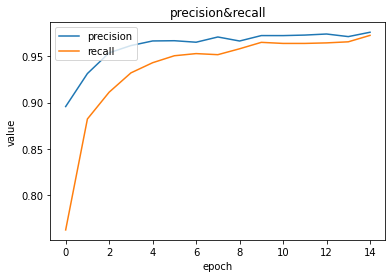

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('precision&recall')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['precision', 'recall'], loc='upper left')
plt.show()

In [ ]:
from statistics import mean
acc = history.history['accuracy']
pre = history.history['precision']
recall = history.history['recall']
print(f'mean accuracy is {mean(acc)}')
print(f'mean precision is {mean(pre)}')
print(f'mean recall is {mean(recall)}')

f1 =  (mean(pre)* mean(recall))/(mean(pre) + mean(recall))
f1 = 2 * f1
print(f'f1 score is {f1}')

mean accuracy is 0.9419693271319072
mean precision is 0.9834633946418763
mean recall is 0.9307007312774658
f1 score is 0.9563548790657692
